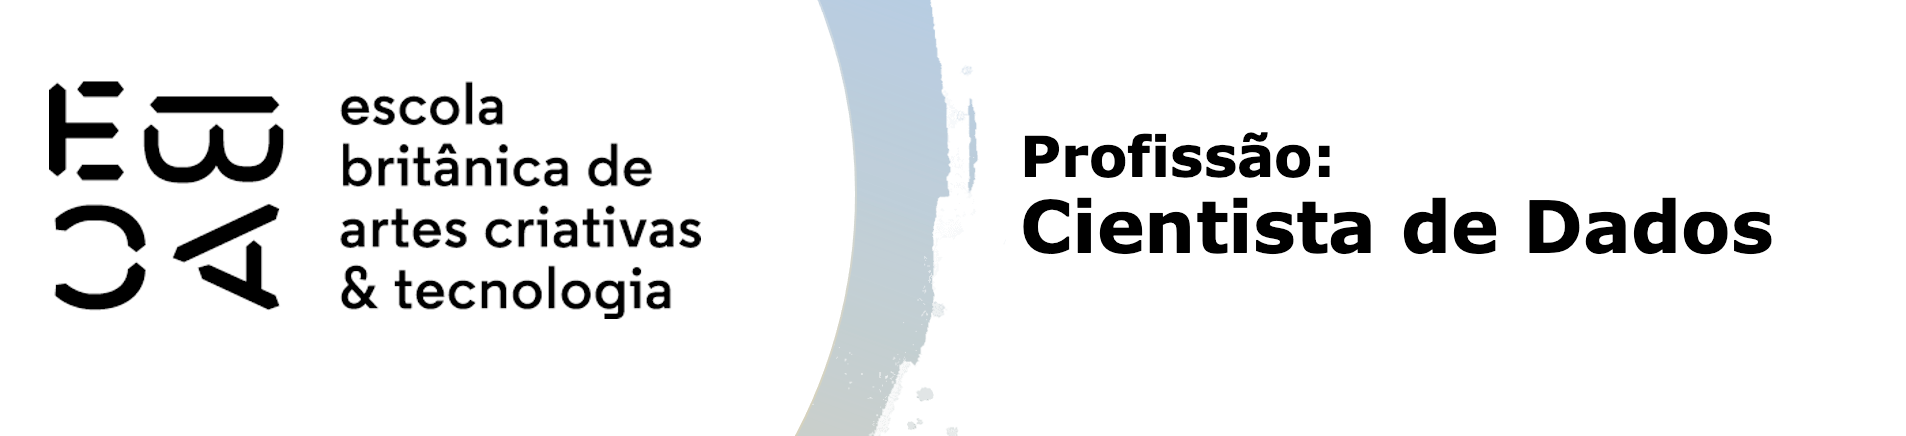

# Regressão III - Tarefa

In [204]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv('previsao_de_renda_II.csv')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda
0,2015-01-01,5762,M,S,N,0,Empresário,Superior completo,Casado,Casa,47,16.717808,2.0,11138.14
1,2015-01-01,1279,M,S,N,0,Assalariado,Superior incompleto,Casado,Casa,30,9.600000,2.0,2424.81
2,2015-01-01,14111,M,S,N,0,Assalariado,Superior completo,Casado,Casa,28,8.208219,2.0,13749.66
3,2015-01-01,8189,M,N,S,2,Assalariado,Médio,Casado,Casa,44,1.301370,4.0,2361.84
4,2015-01-01,1830,F,N,S,2,Assalariado,Superior completo,Casado,Casa,33,1.254795,4.0,790.78


In [ ]:
df.info()

## Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [4]:
# convertendo data para date time
df['data_ref'] = pd.to_datetime(df['data_ref'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624240 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

In [ ]:
df.isna().sum()

In [ ]:
(df.isna().sum()/df.shape[0])

In [5]:
# a única coluna com dados faltantes é a tempo_emprego. que por sinal é 16%.
#obtendo a média da variável
mean_tempo = df.tempo_emprego.mean() # = 7.746164800507006

# substituindo os na pela média
df.tempo_emprego = df.tempo_emprego.fillna(mean_tempo)
df.isna().sum()

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64

In [6]:
# removendo duplicatas 
# total na base = 475452
df = df.drop_duplicates()

### Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [ ]:
df.data_ref.value_counts().sort_index()

In [7]:
# separando os últimos 3 meses para teste
x_test = df.loc[df['data_ref'].isin(['2016-01-01', '2016-02-01', '2016-03-01'])].copy()
y_test = x_test['renda']
x_test = x_test.drop(columns = ['data_ref','index'])
x_test = pd.get_dummies(x_test) # smf não funciona com var quali

# processo para remover o char espaço do nomes de algumas variáveis
names = x_test.columns 
names1 = [n.replace(' ', '_') for n in names]
x_test.columns = names1 # replace no nome das colunas

# o resto para treino
x_train = df.loc[~df['data_ref'].isin(['2016-01-01', '2016-02-01', '2016-03-01'])].copy()
y_train = x_train['renda']
x_train = x_train.drop(columns = ['data_ref','index'])
x_train = pd.get_dummies(x_train) # smf não funciona com var quali
x_train.columns = names1


<ipython-input-7-d42ec4e994c1>:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  x_test = df.loc[df['data_ref'].isin(['2016-01-01', '2016-02-01', '2016-03-01'])].copy()
<ipython-input-7-d42ec4e994c1>:13: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  x_train = df.loc[~df['data_ref'].isin(['2016-01-01', '2016-02-01', '2016-03-01'])].copy()


In [8]:
print(x_test.columns)
print(x_test.shape)
print(y_test.shape)
print(x_train.shape)
print(y_train.shape)
# aparentemente tudo foi separado

Index(['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'sexo_F', 'sexo_M', 'posse_de_veiculo_N', 'posse_de_veiculo_S',
       'posse_de_imovel_N', 'posse_de_imovel_S', 'tipo_renda_Assalariado',
       'tipo_renda_Bolsista', 'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_Servidor_público',
       'educacao_Fundamental', 'educacao_Médio', 'educacao_Pós_graduação',
       'educacao_Superior_completo', 'educacao_Superior_incompleto',
       'estado_civil_Casado', 'estado_civil_Separado', 'estado_civil_Solteiro',
       'estado_civil_União', 'estado_civil_Viúvo', 'tipo_residencia_Aluguel',
       'tipo_residencia_Casa', 'tipo_residencia_Com_os_pais',
       'tipo_residencia_Comunitário', 'tipo_residencia_Estúdio',
       'tipo_residencia_Governamental'],
      dtype='object')
(63395, 32)
(63395,)
(211153, 32)
(211153,)


In [ ]:
x_train.info()

### Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [9]:
res = smf.ols('renda ~ qtd_filhos + idade + tempo_emprego + qt_pessoas_residencia + sexo_F + sexo_M + posse_de_veiculo_N + posse_de_veiculo_S + posse_de_imovel_N + posse_de_imovel_S + tipo_renda_Assalariado + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista + tipo_renda_Servidor_público + educacao_Fundamental + educacao_Médio + educacao_Pós_graduação + educacao_Superior_completo + educacao_Superior_incompleto + estado_civil_Casado + estado_civil_Separado + estado_civil_Solteiro + estado_civil_União + estado_civil_Viúvo + tipo_residencia_Aluguel + tipo_residencia_Casa + tipo_residencia_Com_os_pais + tipo_residencia_Comunitário + tipo_residencia_Estúdio + tipo_residencia_Governamental',data=x_train).fit()
resumo = res.summary()

In [10]:
print(resumo.tables[0])
tabela = pd.read_html(resumo.tables[1].as_html(), header=0, index_col=0)[0]
tabela.style.format(decimal=',', precision=4)\
    .highlight_between(
        right=.05
        , axis=1
        , props='color:red'
        , subset='P>|t|'
    ).set_properties(**{'background-color': '#ffffb3'}, subset=['[0.025', '0.975]'])

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     2877.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:18:35   Log-Likelihood:            -2.6947e+06
No. Observations:              211153   AIC:                         5.389e+06
Df Residuals:                  211128   BIC:                         5.390e+06
Df Model:                          24                                         
Covariance Type:            nonrobust                                         


<ipython-input-10-ea064572e856>:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tabela = pd.read_html(resumo.tables[1].as_html(), header=0, index_col=0)[0]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,"-15300,0000","1645,1410","-9,2980","0,0000","-18500,0000","-12100,0000"
sexo_F[T.True],"-6089,9009","852,4610","-7,1440","0,0000","-7760,7040","-4419,0980"
sexo_M[T.True],"-9206,5549","849,0430","-10,8430","0,0000","-10900,0000","-7542,4520"
posse_de_veiculo_N[T.True],"-7074,8016","846,6780","-8,3560","0,0000","-8734,2690","-5415,3340"
posse_de_veiculo_S[T.True],"-8221,6543","849,6410","-9,6770","0,0000","-9886,9290","-6556,3790"
posse_de_imovel_N[T.True],"-10630,0000","845,6920","-12,5730","0,0000","-12300,0000","-8975,7160"
posse_de_imovel_S[T.True],"-4663,2057","848,2300","-5,4980","0,0000","-6325,7150","-3000,6970"
tipo_renda_Assalariado[T.True],"9409,3668","1695,0800","5,5510","0,0000","6087,0510","12700,0000"
tipo_renda_Bolsista[T.True],"-29720,0000","7123,1670","-4,1720","0,0000","-43700,0000","-15800,0000"
tipo_renda_Empresário[T.True],"12220,0000","1709,3030","7,1470","0,0000","8867,0290","15600,0000"


> Ao avaliar o R2 ajustado, o modelo se mostrou tão fraco quanto possível. obviamente que isso ocorreria pela quantidade de variáveis que participam, portanto um proxímo passo seria avaliar quais variáveis devem ou não participar do modelo.

> Pela tabela summary, quando não removidas as duplicatas, somente as variáveis ```idade```e ```tempo_emprego``` parecem ter alguma relevância.

> Mas quando feita a remoção de duplicatas, outras variáveis apresentam relevância

### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [141]:
# Cada linha é uma categoria
x_train['tempo_emprego_cat'], quebras = pd.qcut(x_train.tempo_emprego, 20, duplicates='drop', retbins=True)

In [142]:
#Uma coluna para a quantidade de observações de cada categoria
tempo_emprego_cat = pd.DataFrame(x_train['tempo_emprego_cat'].value_counts())

In [143]:
#Uma coluna para a média do log-renda para cada categoria
x_train['log_renda'] = np.log(x_train.renda)
renda = pd.DataFrame(x_train.groupby('tempo_emprego_cat')['log_renda'].mean())

<ipython-input-143-c718dc7c01d1>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  renda = pd.DataFrame(x_train.groupby('tempo_emprego_cat')['log_renda'].mean())


In [144]:
# juntando df renda e df tempo com join e mantendo o index renda pq ele está melhor organizado
tab = renda.join(tempo_emprego_cat)

#Uma coluna para a média do tempo de emprego para cada categoria
tab['mean_tempo'] = x_train.groupby('tempo_emprego_cat')['tempo_emprego'].mean()
tab = tab.reset_index()
tab.to_csv('./tab.csv', index = False)

<ipython-input-144-af877d1ba6e8>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab['mean_tempo'] = x_train.groupby('tempo_emprego_cat')['tempo_emprego'].mean()


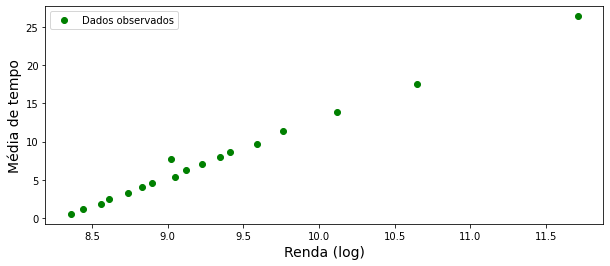

In [145]:
#gráfico
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(tab.log_renda, tab.mean_tempo, "go", label="Dados observados", alpha=1)
plt.ylabel('Média de tempo', fontsize = 14)
plt.xlabel('Renda (log)', fontsize = 14)
ax.legend()

> Honestamente, os dados me parecem estar bem alinhados. Há um outlier por causa do valor da média ser muito superior aos demais. No entanto, é possível perceber uma curva ascendente.

### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [168]:
def esp_vs_obs(data):
    pred_ols = res.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    
    m_l = pred_ols.summary_frame()["mean_ci_lower"]
    m_u = pred_ols.summary_frame()["mean_ci_upper"]

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(data.tempo_emprego_cat, data.log_renda, "o", label="Dados observados")
    ax.plot(data.tempo_emprego_cat, data.log_renda_mean, "b-", label="Média da simulação")
    ax.plot(data.tempo_emprego_cat, res.fittedvalues, "r--.", label="Estimativa OLS")
    ax.plot(data.tempo_emprego_cat, iv_u, "r--", label = 'Banda de confiança para y')
    ax.plot(data.tempo_emprego_cat, iv_l, "r--")
    ax.plot(data.tempo_emprego_cat, m_u, "g:", label='Banda de confiança para a média')
    ax.plot(data.tempo_emprego_cat, m_l, "g:")
    ax.legend(loc="best")
    plt.show

In [39]:
#rodando o modelo com renda e tempo emprego
res = smf.ols('log_renda ~ tempo_emprego_cat', data = x_train).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

R-quadrado: 41.80%


In [40]:
res.summary()
# Em relação ao primeiro modelo o r quadrado caiu logo de cara quando usada a variável pura "renda". O que de alguma forma era esperado.
# Contudo ao usar a variavel "log renda", o R subiu

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     8920.
Date:                Tue, 28 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:33:37   Log-Likelihood:            -2.8321e+05
No. Observations:              211153   AIC:                         5.664e+05
Df Residuals:                  211135   BIC:                         5.666e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------
Intercept                                                         8.3597      0.009    936.007      0.000       8.342       8.377
tempo_emprego_cat[T.Interval(0.827, 1.468, closed='right')]       0.0810      0.013      6.365      0.000       0.056       0.106
tempo_emprego_cat[T.Interval(1.468, 2.11, closed='right')]        0.1980      0.013     15.606      0.000       0.173       0.223
tempo_emprego_cat[T.Interval(2.11, 2.934, closed='right')]        0.2521      0.013     19.856      0.000       0.227       0.277
tempo_emprego_cat[T.Interval(2.934, 3.647, closed='right')]       0.3805      0.013     29.997      0.000       0.356       0.405
tempo_emprego_cat[T.Interval(3.647, 4.304, closed='right')]       0.4725      0.013     37.281      0.000       0.448       0.497
tempo_emprego_cat[T.Interval(4.304, 4.959, closed='right')]       0.5337      0.013     42.068      0.000       0.509       0.559
tempo_emprego_cat[T.Interval(4.959, 5.778, closed='right')]       0.6853      0.013     54.064      0.000       0.660       0.710
tempo_emprego_cat[T.Interval(5.778, 6.638, closed='right')]       0.7586      0.013     59.871      0.000       0.734       0.783
tempo_emprego_cat[T.Interval(6.638, 7.526, closed='right')]       0.8693      0.013     68.552      0.000       0.844       0.894
tempo_emprego_cat[T.Interval(7.526, 7.746, closed='right')]       0.6614      0.010     65.457      0.000       0.642       0.681
tempo_emprego_cat[T.Interval(7.746, 8.107, closed='right')]       0.9852      0.017     56.474      0.000       0.951       1.019
tempo_emprego_cat[T.Interval(8.107, 9.093, closed='right')]       1.0521      0.013     83.090      0.000       1.027       1.077
tempo_emprego_cat[T.Interval(9.093, 10.43, closed='right')]       1.2281      0.013     96.684      0.000       1.203       1.253
tempo_emprego_cat[T.Interval(10.43, 12.461, closed='right')]      1.3990      0.013    110.277      0.000       1.374       1.424
tempo_emprego_cat[T.Interval(12.461, 15.219, closed='right')]     1.7586      0.013    139.038      0.000       1.734       1.783
tempo_emprego_cat[T.Interval(15.219, 20.195, closed='right')]     2.2888      0.013    180.047      0.000       2.264       2.314
tempo_emprego_cat[T.Interval(20.195, 42.907, closed='right')]     3.3518      0.013    264.153      0.000       3.327       3.377
==============================================================================
Omnibus:                      164.185   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.390
Skew:                          -0.020   Prob(JB):                     1.63e-32
Kurtosis:                       2.878

#### 1 - Categorização

In [41]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211153 entries, 0 to 599996
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   qtd_filhos                     211153 non-null  int64   
 1   idade                          211153 non-null  int64   
 2   tempo_emprego                  211153 non-null  float64 
 3   qt_pessoas_residencia          211153 non-null  float64 
 4   renda                          211153 non-null  float64 
 5   sexo_F                         211153 non-null  bool    
 6   sexo_M                         211153 non-null  bool    
 7   posse_de_veiculo_N             211153 non-null  bool    
 8   posse_de_veiculo_S             211153 non-null  bool    
 9   posse_de_imovel_N              211153 non-null  bool    
 10  posse_de_imovel_S              211153 non-null  bool    
 11  tipo_renda_Assalariado         211153 non-null  bool    
 12  tipo_renda_Bolsista  

In [146]:
# Aplicando as linearizações por categorização
# Usarei já a tabela de perfil com log de renda e as categorizações.
# Isso pq quando fiz a categorização com os dados originais, ficou impossível de acompanhar as quebras

# tab['tempo_emprego_cat'] = tab['tempo_emprego_cat'].astype(str)
# x_train['tempo_emprego_cat'] = x_train['tempo_emprego_cat'].astype(str)

sem_values = x_train.groupby('tempo_emprego_cat')['log_renda'].sem()
sem_values = sem_values.reindex(tab['tempo_emprego_cat'])  # Alinhar
tab['log_renda_min'] = tab['log_renda'] - 2 * sem_values.values
tab['log_renda_max'] = tab['log_renda'] + 2* sem_values.values

tab['renda_mean'] = x_train.groupby('tempo_emprego_cat')['renda'].mean()
tab.rename(columns={'log_renda':'log_renda_mean'}, inplace=True)

tab.head()

<ipython-input-146-4fde37177ef4>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sem_values = x_train.groupby('tempo_emprego_cat')['log_renda'].sem()
<ipython-input-146-4fde37177ef4>:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab['renda_mean'] = x_train.groupby('tempo_emprego_cat')['renda'].mean()


,tempo_emprego_cat,log_renda_mean,count,mean_tempo,log_renda_min,log_renda_max,renda_mean
0,"(0.11699999999999999, 0.827]",8.359684,10733,0.521538,8.342150,8.377218,NaN
1,"(0.827, 1.468]",8.440655,10435,1.135439,8.422322,8.458988,7185.342508
2,"(1.468, 2.11]",8.557645,10551,1.793564,8.539693,8.575598,7888.087649
3,"(2.11, 2.934]",8.611740,10521,2.524534,8.593463,8.630018,9555.440764
4,"(2.934, 3.647]",8.740216,10549,3.309509,8.722070,8.758363,10769.709050


In [147]:
# criando uma nova tabela que incorpora os dados da xtrain e as novas feats da tab
tmp = x_train.merge(tab, on='tempo_emprego_cat', how='left')

#tmp.to_csv('./tmp.csv', index = False)
tmp.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,posse_de_imovel_N,...,tipo_residencia_Estúdio,tipo_residencia_Governamental,tempo_emprego_cat,log_renda,log_renda_mean,count,mean_tempo,log_renda_min,log_renda_max,renda_mean
0,0,47,16.717808,2.0,11138.14,False,True,False,True,True,...,False,False,"(15.219, 20.195]",9.318131,10.648473,10462,17.559677,10.629985,10.666962,65393.019280
1,0,30,9.600000,2.0,2424.81,False,True,False,True,True,...,False,False,"(9.093, 10.43]",7.793508,9.587805,10494,9.747040,9.569940,9.605670,36443.602267
2,0,28,8.208219,2.0,13749.66,False,True,False,True,True,...,False,False,"(8.107, 9.093]",9.528769,9.411757,10628,8.580666,9.393957,9.429557,25430.408807
3,2,44,1.301370,4.0,2361.84,False,True,True,False,False,...,False,False,"(0.827, 1.468]",7.767196,8.440655,10435,1.135439,8.422322,8.458988,7185.342508
4,2,33,1.254795,4.0,790.78,True,False,True,False,False,...,False,False,"(0.827, 1.468]",6.673020,8.440655,10435,1.135439,8.422322,8.458988,7185.342508


In [54]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211153 entries, 0 to 211152
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype   
---  ------                         --------------   -----   
 0   qtd_filhos                     211153 non-null  int64   
 1   idade                          211153 non-null  int64   
 2   tempo_emprego                  211153 non-null  float64 
 3   qt_pessoas_residencia          211153 non-null  float64 
 4   renda                          211153 non-null  float64 
 5   sexo_F                         211153 non-null  bool    
 6   sexo_M                         211153 non-null  bool    
 7   posse_de_veiculo_N             211153 non-null  bool    
 8   posse_de_veiculo_S             211153 non-null  bool    
 9   posse_de_imovel_N              211153 non-null  bool    
 10  posse_de_imovel_S              211153 non-null  bool    
 11  tipo_renda_Assalariado         211153 non-null  bool    
 12  tipo_renda_Bolsi

In [138]:
tmp = pd.read_csv('./tmp.csv')

In [148]:
#Ordenando os valores para garantir um gráfico coerente
tmp = tmp.sort_values(by="tempo_emprego_cat")
tmp['tempo_emprego_cat'] = tmp['tempo_emprego_cat'].astype(str)

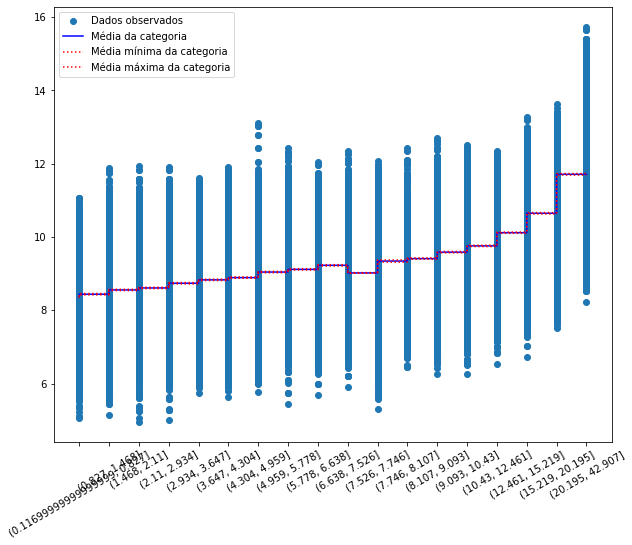

In [149]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tmp.tempo_emprego_cat, tmp.log_renda, "o", label="Dados observados", alpha=1)
plt.xticks(rotation=30) 
ax.step(tmp.tempo_emprego_cat, tmp.log_renda_mean, "b-", label="Média da categoria", alpha=1)
ax.step(tmp.tempo_emprego_cat, tmp.log_renda_min, "r:", label="Média mínima da categoria", alpha=1)
ax.step(tmp.tempo_emprego_cat, tmp.log_renda_max, "r:", label="Média máxima da categoria", alpha=1)
ax.legend()

In [124]:
quebras

array([ 0.11780822,  0.82739726,  1.46849315,  2.10958904,  2.93424658,
        3.64657534,  4.30410959,  4.95890411,  5.77808219,  6.63835616,
        7.5260274 ,  7.7461648 ,  8.10684932,  9.09315068, 10.43013699,
       12.46082192, 15.21917808, 20.19452055, 42.90684932])

In [163]:
quebras2 = (-np.inf, 6.63835616, 9.09315068, 20.19452055, 42.90684932)

# aplicando a nova quebra
x_train['tempo_emprego_cat'] = pd.cut(x_train['tempo_emprego'], quebras2)

#REPETINDO OS PASSOS ANTEIORES PARA A CRIAÇÃO DE UMA NOVA TABELA COM OS DADOS ATUALIZADOS

tempo_emprego_cat = pd.DataFrame(x_train['tempo_emprego_cat'].value_counts())

renda = pd.DataFrame(x_train.groupby('tempo_emprego_cat')['log_renda'].mean())
tab = renda.join(tempo_emprego_cat)

#Uma coluna para a média do tempo de emprego para cada categoria
tab['mean_tempo'] = x_train.groupby('tempo_emprego_cat')['tempo_emprego'].mean()
tab = tab.reset_index()

sem_values = x_train.groupby('tempo_emprego_cat')['log_renda'].sem()
sem_values = sem_values.reindex(tab['tempo_emprego_cat'])  # Alinhar
tab['log_renda_min'] = tab['log_renda'] - 2 * sem_values.values
tab['log_renda_max'] = tab['log_renda'] + 2* sem_values.values

tab['renda_mean'] = x_train.groupby('tempo_emprego_cat')['renda'].mean()
tab.rename(columns={'log_renda':'log_renda_mean'}, inplace=True)

tmp = x_train.merge(tab, on='tempo_emprego_cat', how='left')

tmp = tmp.sort_values(by="tempo_emprego_cat")
tmp['tempo_emprego_cat'] = tmp['tempo_emprego_cat'].astype(str)

tmp.head()

<ipython-input-163-675e9004b636>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  renda = pd.DataFrame(x_train.groupby('tempo_emprego_cat')['log_renda'].mean())
<ipython-input-163-675e9004b636>:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab['mean_tempo'] = x_train.groupby('tempo_emprego_cat')['tempo_emprego'].mean()
<ipython-input-163-675e9004b636>:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sem_values = x_

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,posse_de_imovel_N,...,tipo_residencia_Estúdio,tipo_residencia_Governamental,tempo_emprego_cat,log_renda,log_renda_mean,count,mean_tempo,log_renda_min,log_renda_max,renda_mean
211152,0,44,2.345205,2.0,3080.48,False,True,False,True,False,...,True,False,"(-inf, 6.638]",8.032841,8.732504,94872,3.275424,8.726284,8.738724,9734.266787
155306,2,45,0.909589,4.0,3153.48,False,True,True,False,False,...,False,False,"(-inf, 6.638]",8.056262,8.732504,94872,3.275424,8.726284,8.738724,9734.266787
155307,0,43,5.715068,2.0,5639.27,True,False,True,False,True,...,False,False,"(-inf, 6.638]",8.637510,8.732504,94872,3.275424,8.726284,8.738724,9734.266787
155308,0,23,3.386301,1.0,20964.06,False,True,False,True,True,...,False,True,"(-inf, 6.638]",9.950565,8.732504,94872,3.275424,8.726284,8.738724,9734.266787
155309,1,37,4.046575,3.0,26562.73,True,False,False,True,False,...,False,False,"(-inf, 6.638]",10.187264,8.732504,94872,3.275424,8.726284,8.738724,9734.266787


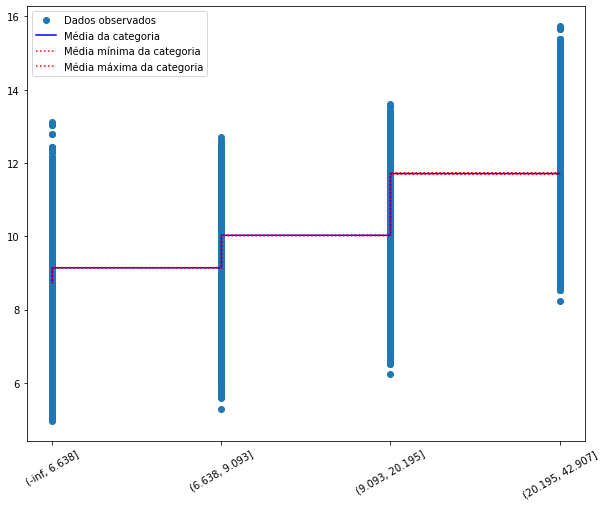

In [164]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(tmp.tempo_emprego_cat, tmp.log_renda, "o", label="Dados observados", alpha=1)
plt.xticks(rotation=30) 
ax.step(tmp.tempo_emprego_cat, tmp.log_renda_mean, "b-", label="Média da categoria", alpha=1)
ax.step(tmp.tempo_emprego_cat, tmp.log_renda_min, "r:", label="Média mínima da categoria", alpha=1)
ax.step(tmp.tempo_emprego_cat, tmp.log_renda_max, "r:", label="Média máxima da categoria", alpha=1)
ax.legend()

R-quadrado: 37.18%


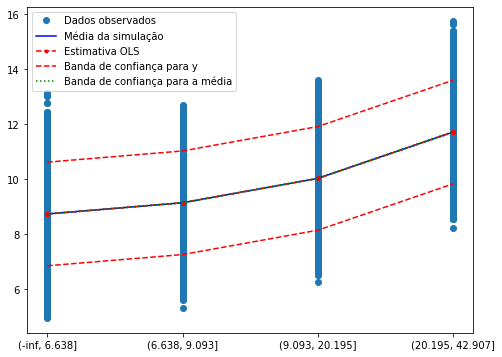

In [169]:
res = smf.ols('log_renda ~ tempo_emprego_cat',data=tmp).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs(tmp);

#### 2 - Lowess

In [ ]:
x_train.columns

In [171]:
# Selecionar variáveis de interesse para a análise LOWESS

X_lowess = x_train["tempo_emprego"]
y_lowess = x_train["log_renda"]

# Aplicar LOWESS
lowess = sm.nonparametric.lowess(y_lowess, X_lowess, frac=2 / 3)

# Valores suavizados
lowess_y = lowess[:, 1]
lowess_x = lowess[:, 0]

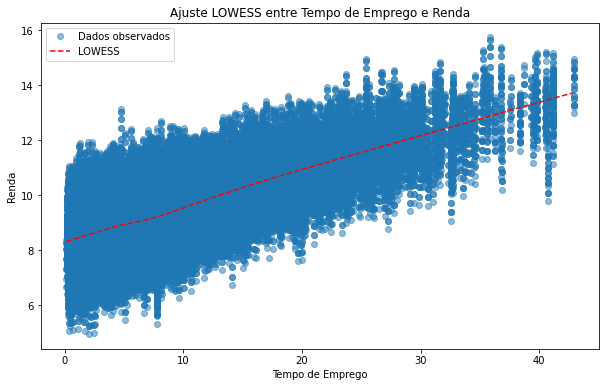

In [174]:
# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(X_lowess, y_lowess, "o", label="Dados observados", alpha=0.5)
ax.plot(lowess[:, 0], lowess_y, "r--", label="LOWESS")
ax.set_xlabel("Tempo de Emprego")
ax.set_ylabel("Renda")
ax.set_title("Ajuste LOWESS entre Tempo de Emprego e Renda")
ax.legend()
plt.show()

In [175]:
# Roda a interpolação do scipy
f = interp1d(lowess_x, lowess_y, bounds_error=False)

x_train['tempo_emprego_lowess'] = f(x_train.tempo_emprego)
x_train.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,sexo_F,sexo_M,posse_de_veiculo_N,posse_de_veiculo_S,posse_de_imovel_N,...,estado_civil_Viúvo,tipo_residencia_Aluguel,tipo_residencia_Casa,tipo_residencia_Com_os_pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental,tempo_emprego_cat,log_renda,tempo_emprego_lowess
0,0,47,16.717808,2.0,11138.14,False,True,False,True,True,...,False,False,True,False,False,False,False,"(9.093, 20.195]",9.318131,10.511404
1,0,30,9.600000,2.0,2424.81,False,True,False,True,True,...,False,False,True,False,False,False,False,"(9.093, 20.195]",7.793508,9.476120
2,0,28,8.208219,2.0,13749.66,False,True,False,True,True,...,False,False,True,False,False,False,False,"(6.638, 9.093]",9.528769,9.268477
3,2,44,1.301370,4.0,2361.84,False,True,True,False,False,...,False,False,True,False,False,False,False,"(-inf, 6.638]",7.767196,8.471846
4,2,33,1.254795,4.0,790.78,True,False,True,False,False,...,False,False,True,False,False,False,False,"(-inf, 6.638]",6.673020,8.465701


In [184]:
def esp_vs_obs(data):
    pred_ols = res.get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    
    m_l = pred_ols.summary_frame()["mean_ci_lower"]
    m_u = pred_ols.summary_frame()["mean_ci_upper"]

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(data.tempo_emprego_lowess, data.log_renda, "o", label="Dados observados")
    #ax.plot(data.tempo_emprego_lowess, data.log_renda_mean, "b-", label="Média da simulação")
    ax.plot(data.tempo_emprego_lowess, res.fittedvalues, "r--.", label="Estimativa OLS")
    ax.plot(data.tempo_emprego_lowess, iv_u, "r--", label = 'Banda de confiança para y')
    ax.plot(data.tempo_emprego_lowess, iv_l, "r--")
    ax.plot(data.tempo_emprego_lowess, m_u, "g:", label='Banda de confiança para a média')
    ax.plot(data.tempo_emprego_lowess, m_l, "g:")
    ax.legend(loc="best")
    plt.show

R-quadrado: 42.35%


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_renda   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.424
Method:                 Least Squares   F-statistic:                 1.551e+05
Date:                Tue, 28 Jan 2025   Prob (F-statistic):               0.00
Time:                        15:56:35   Log-Likelihood:            -2.8220e+05
No. Observations:              211153   AIC:                         5.644e+05
Df Residuals:                  211151   BIC:                         5.644e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0146      0.024      0.620      0.535      -0.032       0.061
tempo_emprego_lowess     0.9974      0.003    393.855      0.000       0.992       1.002
==============================================================================
Omnibus:                      267.662   Durbin-Watson:                   1.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.479
Skew:                          -0.037   Prob(JB):                     4.46e-52
Kurtosis:                       2.854   Cond. No.                         111.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

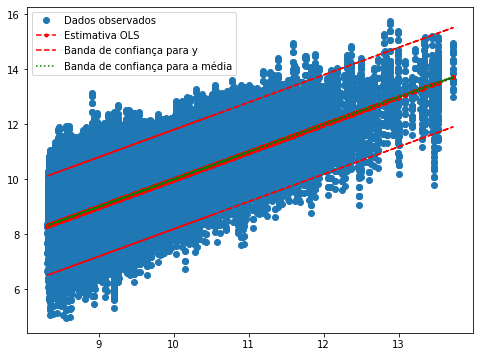

In [186]:
res = smf.ols('log_renda ~ tempo_emprego_lowess',data=x_train).fit()
print(f'R-quadrado: {res.rsquared:.2%}')

esp_vs_obs(x_train);

res.summary()

In [188]:
x_train.to_csv('./xtrain_tratada.csv', index = False)

> O modelo aplicando a linearização lowess demostrou um R quadrado um pouco melhor. Vou usa-lo para a base de teste.

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

In [192]:
x_test['log_renda'] = np.log(x_test['renda'])

In [194]:
#Aplicando lowess na base de teste

X_lowess = x_test["tempo_emprego"]
y_lowess = x_test["log_renda"]

# Aplicar LOWESS
lowess = sm.nonparametric.lowess(y_lowess, X_lowess, frac=2 / 3)

# Valores suavizados
lowess_y = lowess[:, 1]
lowess_x = lowess[:, 0]

In [196]:
f = interp1d(lowess_x, lowess_y, bounds_error=False)

x_test['tempo_emprego_lowess'] = f(x_test.tempo_emprego)

In [206]:
# criando os objetos para avaliar o modelo
y_pred = res.predict(x_test)

y_test = x_test['log_renda']

In [207]:
# Calcularndo as métricas
mae = mean_absolute_error(y_test, y_pred)  # MAE
mse = mean_squared_error(y_test, y_pred)  # MSE
rmse = np.sqrt(mse)                       # RMSE
r2 = r2_score(y_test, y_pred)             # R²

# Exibir os resultados
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")

MAE: 0.5988029501094059
MSE: 0.5655107851451601
RMSE: 0.7520045113861752
R²: 0.5252897383585631


#### Avaliação Final

> No final o modelo ficou um pouco melhor. no início contávamos com 0.41 e ao final com 0.52, uma subida significativa. contudo o valor não é tão satisfatório e outros ajustes de parâmetros poderiam ser realizados
